In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
weather_dataset = pd.read_csv('weatherHistory.csv')

# Data Visualization

In [3]:
weather_dataset.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [4]:
weather_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [5]:
weather_dataset["Precip Type"].value_counts()

Precip Type
rain    85224
snow    10712
Name: count, dtype: int64

In [6]:
weather_dataset["Summary"].value_counts()

Summary
Partly Cloudy                          31733
Mostly Cloudy                          28094
Overcast                               16597
Clear                                  10890
Foggy                                   7148
Breezy and Overcast                      528
Breezy and Mostly Cloudy                 516
Breezy and Partly Cloudy                 386
Dry and Partly Cloudy                     86
Windy and Partly Cloudy                   67
Light Rain                                63
Breezy                                    54
Windy and Overcast                        45
Humid and Mostly Cloudy                   40
Drizzle                                   39
Breezy and Foggy                          35
Windy and Mostly Cloudy                   35
Dry                                       34
Humid and Partly Cloudy                   17
Dry and Mostly Cloudy                     14
Rain                                      10
Windy                                      8
Hu

In [7]:
weather_dataset["Temperature (C)"].describe()

count    96453.000000
mean        11.932678
std          9.551546
min        -21.822222
25%          4.688889
50%         12.000000
75%         18.838889
max         39.905556
Name: Temperature (C), dtype: float64

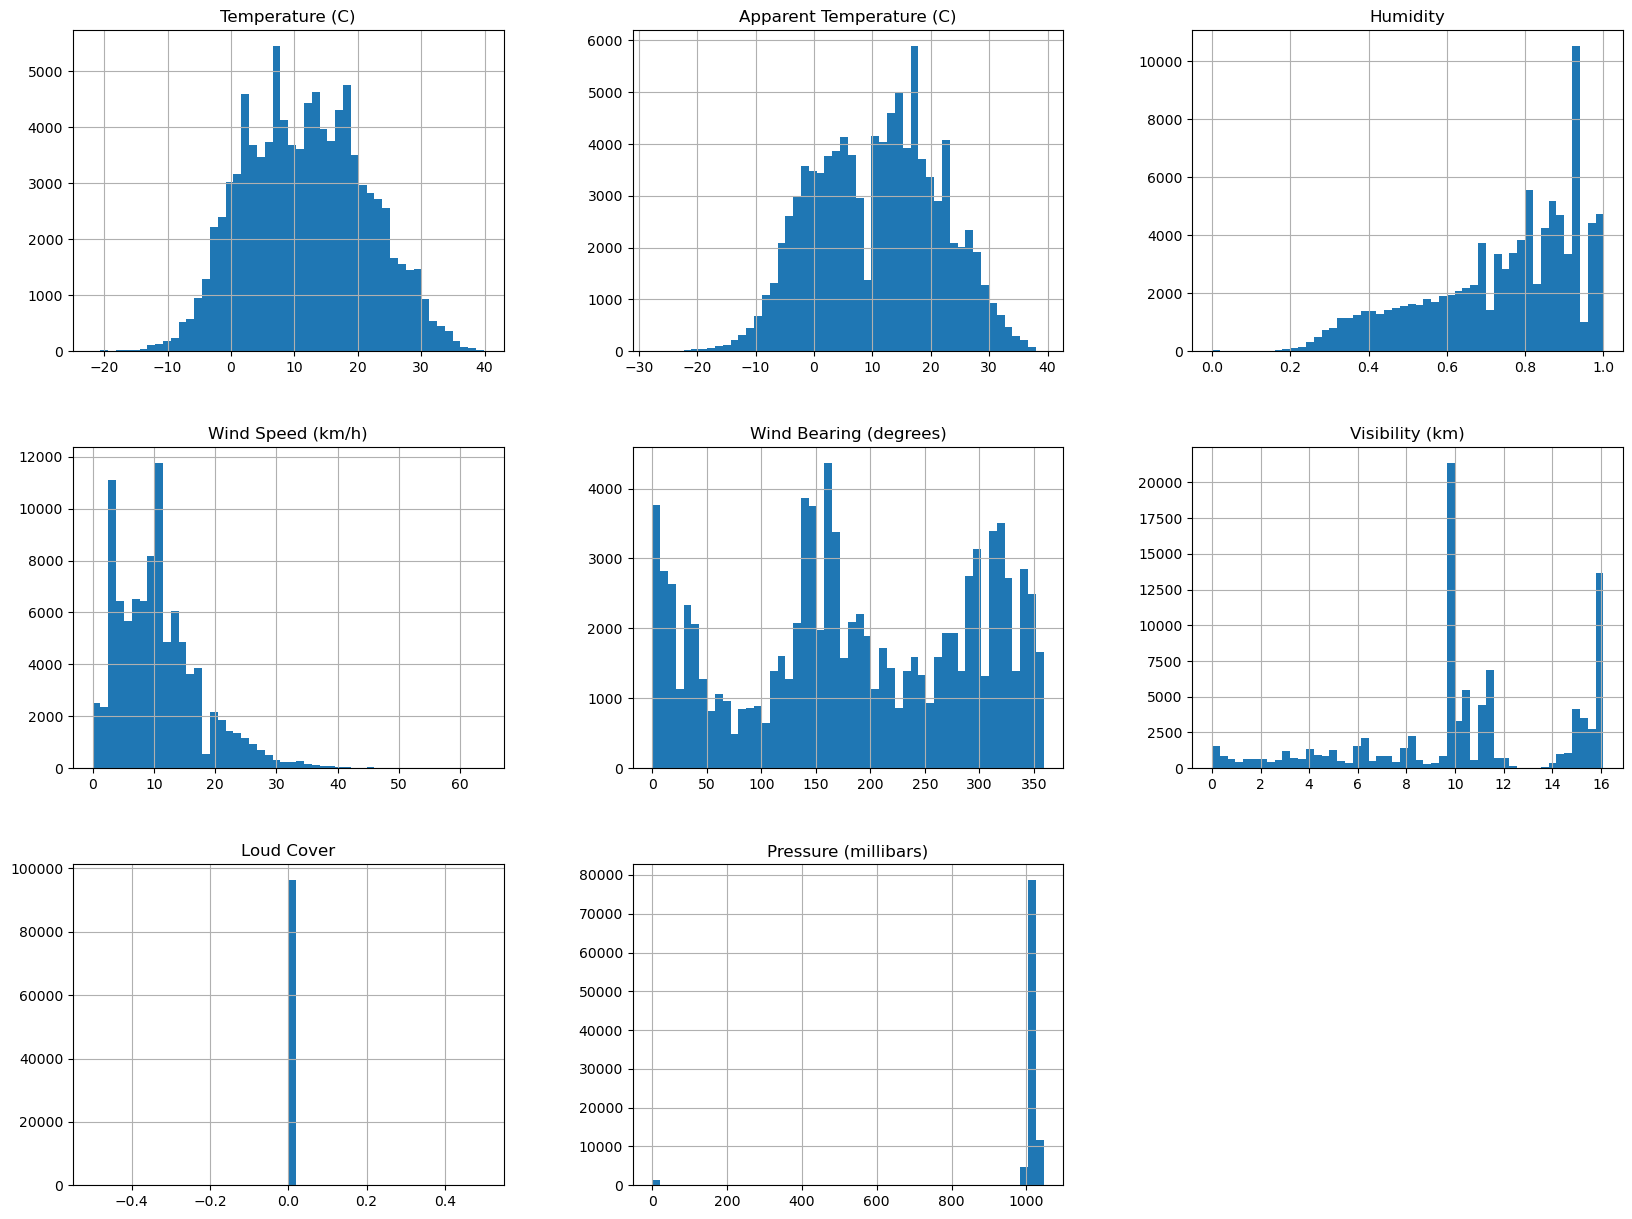

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
weather_dataset.hist(bins=50, figsize=(20,15))
plt.show()

# Data Preprocessing

Data Cleaning

In [9]:
top_classes = ['Overcast', 'Clear', 'Foggy']
weather_dataset = weather_dataset[weather_dataset['Summary'].isin(top_classes)]

In [10]:
weather_dataset["Formatted Date"] = pd.to_datetime(weather_dataset["Formatted Date"], utc=True)
weather_dataset["Month"] = weather_dataset["Formatted Date"].dt.month
weather_dataset["Year"] = weather_dataset["Formatted Date"].dt.year
weather_dataset["Day"] = weather_dataset["Formatted Date"].dt.day
weather_dataset = weather_dataset.drop(["Daily Summary", "Loud Cover", "Formatted Date"], axis=1)


Filling Missing Values

In [11]:
# None indicates no precipitation
weather_dataset["Precip Type"] = weather_dataset["Precip Type"].fillna("None")


Feature Encoding

In [12]:
# Apply one hot encoding to prec type
weather_dataset = pd.get_dummies(weather_dataset, columns=["Precip Type"], drop_first=True)
weather_dataset

,Summary,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Month,Year,Day,Precip Type_rain,Precip Type_snow
46,Overcast,14.422222,14.422222,0.58,20.0123,159.0,15.8263,1007.85,4,2006,10,True,False
47,Overcast,14.255556,14.255556,0.59,16.5025,168.0,14.9569,1007.89,4,2006,10,True,False
48,Overcast,13.772222,13.772222,0.60,17.0982,160.0,15.8263,1007.36,4,2006,10,True,False
49,Overcast,13.283333,13.283333,0.63,14.3612,160.0,15.8263,1007.26,4,2006,10,True,False
50,Overcast,8.633333,5.466667,0.87,22.0409,32.0,6.6976,1005.10,4,2006,11,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96432,Clear,15.594444,15.594444,0.87,3.2844,41.0,15.4399,1014.52,9,2016,9,True,False
96433,Clear,15.011111,15.011111,0.93,3.2039,341.0,15.8263,1014.37,9,2016,9,True,False
96434,Clear,15.016667,15.016667,0.90,2.7048,359.0,14.9569,1014.55,9,2016,9,True,False
96435,Clear,13.872222,13.872222,0.93,4.7495,0.0,15.8263,1014.66,9,2016,9,True,False


Feature Scaling

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

In [14]:
standard_scaler = StandardScaler()
columns_to_standardize = ["Temperature (C)", "Apparent Temperature (C)", "Wind Speed (km/h)", "Visibility (km)", "Pressure (millibars)", "Humidity"]
weather_dataset[columns_to_standardize] = standard_scaler.fit_transform(weather_dataset[columns_to_standardize])


In [15]:
minmax_scaler = MinMaxScaler()
columns_to_normalize = ["Wind Bearing (degrees)"]
weather_dataset[columns_to_normalize] = minmax_scaler.fit_transform(weather_dataset[columns_to_normalize])

In [16]:
label_encoder = LabelEncoder()
weather_dataset["Summary"] = label_encoder.fit_transform(weather_dataset["Summary"])
label_names = label_encoder.classes_

for i, label in enumerate(label_names):
    print(f"{i}: {label}")

0: Clear
1: Foggy
2: Overcast


In [17]:
weather_dataset["Summary"].value_counts()

Summary
2    16597
0    10890
1     7148
Name: count, dtype: int64

In [18]:
weather_dataset.corr().style.background_gradient(cmap='coolwarm')

,Summary,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Month,Year,Day,Precip Type_rain,Precip Type_snow
Summary,1.000000,-0.184228,-0.198971,0.254529,0.290049,0.021862,-0.121083,0.132834,-0.086064,0.098076,-0.023410,0.002154,0.004840
Temperature (C),-0.184228,1.000000,0.988666,-0.508642,0.033614,0.016182,0.455443,-0.061839,0.158044,0.028400,-0.006126,0.631708,-0.641074
Apparent Temperature (C),-0.198971,0.988666,1.000000,-0.474652,-0.070342,0.018794,0.431105,-0.051865,0.174132,0.028897,-0.001490,0.624392,-0.633849
Humidity,0.254529,-0.508642,-0.474652,1.000000,-0.197236,0.044678,-0.490609,0.091596,0.062777,0.072458,0.003901,-0.178647,0.185335
Wind Speed (km/h),0.290049,0.033614,-0.070342,-0.197236,1.000000,0.051535,0.166142,-0.060444,-0.122519,0.030696,-0.033725,0.082813,-0.084786
Wind Bearing (degrees),0.021862,0.016182,0.018794,0.044678,0.051535,1.000000,0.034000,-0.015841,-0.006724,-0.030874,-0.009295,0.028099,-0.028776
Visibility (km),-0.121083,0.455443,0.431105,-0.490609,0.166142,0.034000,1.000000,0.033324,-0.089304,0.012559,-0.043701,0.325526,-0.318994
Pressure (millibars),0.132834,-0.061839,-0.051865,0.091596,-0.060444,-0.015841,0.033324,1.000000,-0.043048,0.003557,-0.024567,-0.038864,0.036086
Month,-0.086064,0.158044,0.174132,0.062777,-0.122519,-0.006724,-0.089304,-0.043048,1.000000,-0.039133,0.065719,0.140014,-0.153312
Year,0.098076,0.028400,0.028897,0.072458,0.030696,-0.030874,0.012559,0.003557,-0.039133,1.000000,0.005418,0.048887,-0.074341


In [19]:
# dropping apparent temperature due to high correlation with temperature
weather_dataset = weather_dataset.drop(["Apparent Temperature (C)"], axis=1)

In [20]:
weather_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34635 entries, 46 to 96436
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Summary                 34635 non-null  int32  
 1   Temperature (C)         34635 non-null  float64
 2   Humidity                34635 non-null  float64
 3   Wind Speed (km/h)       34635 non-null  float64
 4   Wind Bearing (degrees)  34635 non-null  float64
 5   Visibility (km)         34635 non-null  float64
 6   Pressure (millibars)    34635 non-null  float64
 7   Month                   34635 non-null  int32  
 8   Year                    34635 non-null  int32  
 9   Day                     34635 non-null  int32  
 10  Precip Type_rain        34635 non-null  bool   
 11  Precip Type_snow        34635 non-null  bool   
dtypes: bool(2), float64(6), int32(4)
memory usage: 2.4 MB


Splitting the data

In [21]:
X = weather_dataset.drop(["Summary"], axis=1)
y = weather_dataset["Summary"]

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Non-Parametric Models

## 1. kNN

In [45]:
from sklearn.neighbors import KNeighborsClassifier

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'n_neighbors': [1, 2, 3, 5],                   
    'metric': ['euclidean', 'manhattan']        
}

# Grid Search with CV
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=skf, scoring='accuracy', n_jobs=-1, return_train_score=True)
grid.fit(X_train, y_train)

# Show all results
results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)
print("\nAll Evaluated Models:\n")
print(results_df[['params', 'mean_test_score', 'std_test_score']])

# Best Model
print("\nBest Model:\n", grid.best_params_)

# Test on hold-out set
y_pred = grid.predict(X_test)
print("\nClassification Report on Test Set:\n")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))
print("\nAccuracy Score:\n")
print(accuracy_score(y_test, y_pred))
print("\nTraining Score:\n")
print(grid.score(X_train, y_train))



All Evaluated Models:

                                      params  mean_test_score  std_test_score
4  {'metric': 'manhattan', 'n_neighbors': 1}         0.921034        0.003958
0  {'metric': 'euclidean', 'n_neighbors': 1}         0.916378        0.003062
6  {'metric': 'manhattan', 'n_neighbors': 3}         0.903819        0.003176
2  {'metric': 'euclidean', 'n_neighbors': 3}         0.895409        0.003787
5  {'metric': 'manhattan', 'n_neighbors': 2}         0.894759        0.002998
7  {'metric': 'manhattan', 'n_neighbors': 5}         0.891656        0.005065
1  {'metric': 'euclidean', 'n_neighbors': 2}         0.889238        0.002465
3  {'metric': 'euclidean', 'n_neighbors': 5}         0.881406        0.004032

Best Model:
 {'metric': 'manhattan', 'n_neighbors': 1}

Classification Report on Test Set:

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2201
           1       0.90      0.90      0.90      1462
           2      

## 2. Decision Tree

In [46]:
weather_dataset = pd.read_csv('weatherHistory.csv')

from sklearn.tree import DecisionTreeClassifier

top_classes = ['Overcast', 'Clear', 'Foggy']
weather_dataset = weather_dataset[weather_dataset['Summary'].isin(top_classes)]

# None indicates no precipitation
weather_dataset["Precip Type"] = weather_dataset["Precip Type"].fillna("None")

weather_dataset["Formatted Date"] = pd.to_datetime(weather_dataset["Formatted Date"], utc=True)
weather_dataset["Month"] = weather_dataset["Formatted Date"].dt.month
weather_dataset["Year"] = weather_dataset["Formatted Date"].dt.year
weather_dataset["Day"] = weather_dataset["Formatted Date"].dt.day
weather_dataset = weather_dataset.drop(["Daily Summary", "Loud Cover", "Formatted Date", "Apparent Temperature (C)", "Wind Bearing (degrees)"], axis=1)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
weather_dataset["Precip Type"] = label_encoder.fit_transform(weather_dataset["Precip Type"])

label_encoder = LabelEncoder()
weather_dataset["Summary"] = label_encoder.fit_transform(weather_dataset["Summary"])

In [47]:
from sklearn.tree import DecisionTreeClassifier

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



# Define X and y
X = weather_dataset.drop(["Summary"], axis=1)
y = weather_dataset["Summary"]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid for tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 15, 20],                            # No limit on depth
    'min_samples_split': [10, 20, 30],            # Don't split on tiny samples
    'min_samples_leaf': [5, 10, 15],          # Each leaf must have enough data
}


# Initialize the classifier
dt = DecisionTreeClassifier(random_state=42)

# Setup GridSearchCV
grid = GridSearchCV(dt, param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)

# Show all results
results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)
print("\nAll Evaluated Models:\n")
print(results_df[['params', 'mean_test_score', 'std_test_score']])

# Use best estimator to predict
best_dt = grid.best_estimator_
y_pred = best_dt.predict(X_test)

# Evaluation
print("\nClassification Report on Test Set:\n")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))
print("\nAccuracy Score:\n")
print(accuracy_score(y_test, y_pred))

# Train accuracy
train_accuracy = best_dt.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)


Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 10}
Best Cross-Validation Accuracy: 0.8853760728966984

All Evaluated Models:

                                               params  mean_test_score  \
45  {'criterion': 'entropy', 'max_depth': 20, 'min...         0.885376   
18  {'criterion': 'gini', 'max_depth': 20, 'min_sa...         0.881262   
46  {'criterion': 'entropy', 'max_depth': 20, 'min...         0.878771   
9   {'criterion': 'gini', 'max_depth': 15, 'min_sa...         0.878735   
47  {'criterion': 'entropy', 'max_depth': 20, 'min...         0.877544   
19  {'criterion': 'gini', 'max_depth': 20, 'min_sa...         0.877472   
49  {'criterion': 'entropy', 'max_depth': 20, 'min...         0.877436   
48  {'criterion': 'entropy', 'max_depth': 20, 'min...         0.877436   
36  {'criterion': 'entropy', 'max_depth': 15, 'min...         0.876642   
50  {'criterion': 'entropy', 'max_depth': 20, 'min...         0.876425   
22  

## 3. SVM

In [845]:
from sklearn.svm import SVC

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Simplified parameter grid for multiclass
param_grid = {
    'C': [1, 10],          
    'gamma': ['scale', 0.1]
}

# Create grid search with reduced parameters
grid_search = GridSearchCV(
    SVC(random_state=42, decision_function_shape='ovr', kernel="rbf"),  # 'ovr' for multiclass
    param_grid, 
    cv=skf, 
)

grid_search.fit(X_train, y_train)

# Best model evaluation
print("Best Params:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# Evaluate on test set
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Best Params: {'C': 10, 'gamma': 0.1}
Best CV Score: 0.9142123760861178

Test Accuracy: 0.9253645156633463
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      2201
           1       0.95      0.97      0.96      1462
           2       0.92      0.93      0.93      3264

    accuracy                           0.93      6927
   macro avg       0.93      0.93      0.93      6927
weighted avg       0.93      0.93      0.93      6927



# Parametric Models

In [48]:
# import logistic regression
from sklearn.linear_model import LogisticRegression

In [49]:

def add_sin_cos_encoding(df, column_name, max_value):
    df[f"{column_name}_sin"] = np.sin(2 * np.pi * df[column_name] / max_value)
    df[f"{column_name}_cos"] = np.cos(2 * np.pi * df[column_name] / max_value)
    return df

weather_dataset = pd.read_csv('weatherHistory.csv')
top_classes = ['Overcast', 'Clear', 'Foggy']

# Filter the dataset to include only the top classes
weather_dataset = weather_dataset[weather_dataset['Summary'].isin(top_classes)]

# None indicates no precipitation
weather_dataset["Precip Type"] = weather_dataset["Precip Type"].fillna("None")

weather_dataset["Formatted Date"] = pd.to_datetime(weather_dataset["Formatted Date"], utc=True)
weather_dataset["Year"] = weather_dataset["Formatted Date"].dt.year
weather_dataset["Month"] = weather_dataset["Formatted Date"].dt.month
weather_dataset["Day"] = weather_dataset["Formatted Date"].dt.day
weather_dataset["Hour"] = weather_dataset["Formatted Date"].dt.hour
weather_dataset["Day of Week"] = weather_dataset["Formatted Date"].dt.dayofweek
weather_dataset = weather_dataset.drop(["Daily Summary", "Loud Cover", "Formatted Date", "Wind Bearing (degrees)"], axis=1)

# Apply one hot encoding to precip type
weather_dataset = pd.get_dummies(weather_dataset, columns=["Precip Type"], drop_first=True)

# Apply standardization to the dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
standard_scaler = StandardScaler()
columns_to_standardize = ["Temperature (C)", "Apparent Temperature (C)", "Wind Speed (km/h)", "Visibility (km)", "Pressure (millibars)", "Humidity"]
weather_dataset[columns_to_standardize] = standard_scaler.fit_transform(weather_dataset[columns_to_standardize])

minmax_scaler = MinMaxScaler()
columns_to_normalize = ["Year"]
weather_dataset[columns_to_normalize] = minmax_scaler.fit_transform(weather_dataset[columns_to_normalize])

# Add sin/cos encoding for cyclical features
weather_dataset = add_sin_cos_encoding(weather_dataset, "Day", 31)
weather_dataset = add_sin_cos_encoding(weather_dataset, "Month", 12)
weather_dataset = add_sin_cos_encoding(weather_dataset, "Hour", 24)
weather_dataset = add_sin_cos_encoding(weather_dataset, "Day of Week", 7)

label_encoder = LabelEncoder()
weather_dataset["Summary"] = label_encoder.fit_transform(weather_dataset["Summary"])

# dropping apparent temperature due to high correlation with temperature
weather_dataset = weather_dataset.drop(["Apparent Temperature (C)", "Day", "Month", "Hour", "Day of Week"], axis=1)
# Define X and y
X = weather_dataset.drop(["Summary"], axis=1)
y = weather_dataset["Summary"]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# since it is multiclass classification, we will use one-vs-rest strategy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Train Logistic Regression with OvR
logreg_ovr = LogisticRegression(multi_class='ovr', max_iter=3000, random_state=42)
logreg_ovr.fit(X_train, y_train)

# Predict and evaluate
y_pred = logreg_ovr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Train Accuracy:", logreg_ovr.score(X_train, y_train))
print("Test Accuracy:", logreg_ovr.score(X_test, y_test))

Accuracy: 0.8081420528367259
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.68      0.71      2201
           1       0.92      0.95      0.93      1462
           2       0.80      0.83      0.81      3264

    accuracy                           0.81      6927
   macro avg       0.82      0.82      0.82      6927
weighted avg       0.81      0.81      0.81      6927

Confusion Matrix:
 [[1493   66  642]
 [  23 1392   47]
 [ 488   63 2713]]
Train Accuracy: 0.8079976901977768
Test Accuracy: 0.8081420528367259


# Neural Network

In [812]:
# import neural network
from keras.models import Sequential
from keras import layers
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# Load the dataset
weather_dataset = pd.read_csv('weatherHistory.csv')
top_classes = ['Overcast', 'Clear', 'Foggy']
# Filter the dataset to include only the top classes
weather_dataset = weather_dataset[weather_dataset['Summary'].isin(top_classes)]
# None indicates no precipitation
weather_dataset["Precip Type"] = weather_dataset["Precip Type"].fillna("None")
weather_dataset["Formatted Date"] = pd.to_datetime(weather_dataset["Formatted Date"], utc=True)
weather_dataset["Year"] = weather_dataset["Formatted Date"].dt.year
weather_dataset["Month"] = weather_dataset["Formatted Date"].dt.month
weather_dataset["Day"] = weather_dataset["Formatted Date"].dt.day
weather_dataset["Hour"] = weather_dataset["Formatted Date"].dt.hour
weather_dataset["Day of Week"] = weather_dataset["Formatted Date"].dt.dayofweek
weather_dataset = weather_dataset.drop(["Daily Summary", "Loud Cover", "Formatted Date"], axis=1)
# Apply one hot encoding to precip type
weather_dataset = pd.get_dummies(weather_dataset, columns=["Precip Type"], drop_first=True)
# Apply standardization to the dataset
standard_scaler = StandardScaler()
columns_to_standardize = ["Temperature (C)", "Apparent Temperature (C)", "Wind Speed (km/h)", "Visibility (km)", "Pressure (millibars)", "Humidity", "Wind Bearing (degrees)"]
weather_dataset[columns_to_standardize] = standard_scaler.fit_transform(weather_dataset[columns_to_standardize])
minmax_scaler = MinMaxScaler()
columns_to_normalize = ["Year"]
weather_dataset[columns_to_normalize] = minmax_scaler.fit_transform(weather_dataset[columns_to_normalize])
# Add sin/cos encoding for cyclical features
def add_sin_cos_encoding(df, column_name, max_value):
    df[f"{column_name}_sin"] = np.sin(2 * np.pi * df[column_name] / max_value)
    df[f"{column_name}_cos"] = np.cos(2 * np.pi * df[column_name] / max_value)
    return df
weather_dataset = add_sin_cos_encoding(weather_dataset, "Day", 31)
weather_dataset = add_sin_cos_encoding(weather_dataset, "Month", 12)
weather_dataset = add_sin_cos_encoding(weather_dataset, "Hour", 24)
weather_dataset = add_sin_cos_encoding(weather_dataset, "Day of Week", 7)
weather_dataset = add_sin_cos_encoding(weather_dataset, "Wind Bearing (degrees)", 360)
label_encoder = LabelEncoder()
weather_dataset["Summary"] = label_encoder.fit_transform(weather_dataset["Summary"])
# dropping apparent temperature due to high correlation with temperature
weather_dataset = weather_dataset.drop(["Apparent Temperature (C)", "Day", "Month", "Hour", "Day of Week", "Wind Bearing (degrees)"], axis=1)
# Define X and y
X = weather_dataset.drop(["Summary"], axis=1)
y = weather_dataset["Summary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Define the model
nn = Sequential()
nn.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
nn.add(layers.Dense(32, activation='relu'))
nn.add(layers.Dense(16, activation='relu'))
nn.add(layers.Dense(3, activation='softmax'))  # 3 classes for output
# Compile the model
nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train the model
nn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)
# Evaluate the model
train_loss, train_accuracy = nn.evaluate(X_train, y_train)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

# Predict and evaluate
y_pred = mlp.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

c:\Users\PMLS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7230 - loss: 0.5994 - val_accuracy: 0.8185 - val_loss: 0.4220
Epoch 2/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8416 - loss: 0.3707 - val_accuracy: 0.8371 - val_loss: 0.3841
Epoch 3/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8548 - loss: 0.3411 - val_accuracy: 0.8452 - val_loss: 0.3646
Epoch 4/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8509 - loss: 0.3380 - val_accuracy: 0.8593 - val_loss: 0.3342
Epoch 5/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8642 - loss: 0.3180 - val_accuracy: 0.8571 - val_loss: 0.3442
Epoch 6/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8691 - loss: 0.3081 - val_accuracy: 0.8695 - val_loss: 0.3128
Epoch 7/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8692 - loss: 0.2995 - val_accuracy: 0.8621 - val_loss: 0.3152
Epoch 8/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8800 - loss: 0.2825 - val_accuracy: 0.